## Visualize Track results

In [1]:
from pathlib import Path
import cv2
import sys
import numpy as np
from skimage import feature, measure
import live_cell_tracker
from live_cell_tracker.livecell_segment import datasets
import live_cell_tracker.livecell_segment
from live_cell_tracker import livecell_segment
import live_cell_tracker.core.utils
from tqdm import tqdm

seg_path = r"""D:\xing-vimentin-dic-pipeline\src\cxa_segmentation\notebooks\segmentation_results\detectron_model3\restart_day0_Group 1_wellA1_RI_MIP_stitched"""
label_seg_imgs = livecell_segment.datasets.LiveCellImageDataset(seg_path, ext="png")
dir_path = Path(
    r"D:\xing-vimentin-dic-pipeline\src\cxa_segmentation\cxa-data\june_2022_data_8bit_png\restart_day0_Group 1_wellA1_RI_MIP_stitched"
)
raw_imgs = livecell_segment.datasets.LiveCellImageDataset(dir_path, ext="png")


288 png img file paths loaded: 
288 png img file paths loaded: 


### load bbox paths

In [2]:
import json

_track_bbs_path = (
    "detectron_model3_all_track_bbs-restart_day0_Group 1_wellA1_RI_MIP_stitched.json"
)
with open(_track_bbs_path, "r") as in_f:
    json_in = json.load(in_f)
type(json_in[0][0][0])


int

In [3]:
all_track_bbs = [np.array(track_bbs, dtype=int) for track_bbs in json_in]


In [4]:
all_track_bbs[0].shape


(27, 5)

### Manually check bboxes  
 - be careful: coordinates of numpy/skimage/cv2/pixel/rowCol/bbox

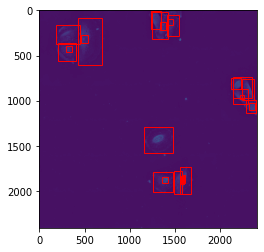

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

idx = 2
bboxes = all_track_bbs[idx]
fig, ax = plt.subplots()
ax.imshow(raw_imgs[idx])
for bbox in bboxes:
    # Create a Rectangle patch
    rect = patches.Rectangle(
        (bbox[1], bbox[0]),
        (bbox[3] - bbox[1]),
        (bbox[2] - bbox[0]),
        linewidth=1,
        edgecolor="r",
        facecolor="none",
    )
    # Add the patch to the Axes
    ax.add_patch(rect)
# plt.show()


Add information to SingleCellTrajectory

In [6]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import os
from live_cell_tracker.core import SingleCellTrajectory, SingleCellStatic, single_cell

id_to_sc_trajs = {}
for timeframe, objects in enumerate(all_track_bbs):
    for obj in objects:
        track_id = obj[-1]
        if not (track_id in id_to_sc_trajs):
            new_traj = SingleCellTrajectory(raw_imgs, track_id=track_id)
            id_to_sc_trajs[track_id] = new_traj
        # print("obj: ", obj)
        sc = SingleCellStatic(
            timeframe, bbox=obj[:4]
        )  # final column is track_id, ignore as we only need bbox here
        _traj = id_to_sc_trajs[track_id]
        _traj.add_timeframe_data(timeframe, sc)


In [ ]:
%matplotlib widget
from typing import List
from live_cell_tracker.track.movie import generate_single_trajectory_movie
output_path = Path("./track_tmp")
output_path.mkdir(exist_ok=True)
for traj_id, traj in id_to_sc_trajs.items():
    generate_single_trajectory_movie(
        traj, raw_imgs, save_path=output_path / "track_{}.gif".format(traj_id)
    )
